<img src="https://thevalley.es/wp-content/uploads/2016/11/thevalley-logo-negro.png" width="400"></img>

# Reto idealista, ¿cuánto vale mi piso?

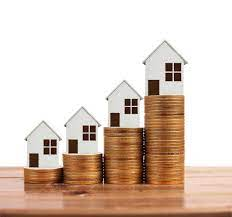


Notebook por: **David Rey**






# Carga de librerías

Cargamos las librerías en nuestro colab, como algunos paquetes no los tenemos instalados realizamos la instalación utilizando [pip](https://packaging.python.org/tutorials/installing-packages/).

In [ ]:
!pip install --upgrade geopandas
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade descartes
!pip install --upgrade rtree
!pip install --upgrade pygeos

import rtree
import pygeos
import geopandas
from geopandas import GeoDataFrame
from shapely import wkt
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

In [ ]:
from IPython.display import display, HTML

# Carga de datos

## Datos de anuncios de idealista

### Anuncios de venta en Barcelona

In [ ]:
# Cargamos los datos de anuncios
anuncios_barcelona = pd.read_csv('https://raw.githubusercontent.com/davidreyblanco/ml-training/master/data/idealista18/data/assets/es_home_sale_Barcelona_2018.csv.gz', sep=";")
anuncios_barcelona.head()

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,...,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_DIAGONAL,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION
0,A11898131848556022319,201803,323000,3845.238095,HOME,SALE,84,4,1,1,...,0,1,1.876290,0.354004,1.475264,2.149566,41.380027,Barcelona,HOME,SALE
1,A18099432772155664747,201803,217000,2583.333333,HOME,SALE,84,3,2,0,...,0,1,2.118595,0.284372,1.194261,2.145689,41.381632,Barcelona,HOME,SALE
2,A2003099089407882787,201803,114000,1407.407407,HOME,SALE,81,2,1,0,...,1,0,4.127099,0.261574,2.504982,2.173891,41.423929,Barcelona,HOME,SALE
3,A1010373782315301134,201803,378000,4784.810127,HOME,SALE,79,2,1,0,...,0,1,2.238113,0.158527,0.795605,2.143379,41.384923,Barcelona,HOME,SALE
4,A12978912200216838006,201803,434000,3909.909910,HOME,SALE,111,4,2,1,...,0,1,2.333066,0.101568,1.200265,2.143230,41.381076,Barcelona,HOME,SALE


In [ ]:
display(HTML(anuncios_barcelona.to_html()))

In [ ]:
anuncios_barcelona.head()

#### Listado de variables

In [ ]:
# generamos la lista de variables del conjunto
for col in anuncios_barcelona.columns:
    print(col)

Descriptivos básicos (hay un error con el campo **-IMPUTED_YEAR**)

In [ ]:
anuncios_barcelona.describe()

### Anuncios de venta en Madrid

In [ ]:
# Cargamos los datos de anuncios
anuncios_madrid = pd.read_csv('https://raw.githubusercontent.com/davidreyblanco/ml-training/master/data/idealista18/data/assets/es_home_sale_Madrid_2018.csv.gz', sep=";")
anuncios_madrid.head()

In [ ]:
anuncios_madrid.describe()

### Anuncios Valencia

In [ ]:
# Cargamos los datos de anuncios
anuncios_valencia = pd.read_csv('https://raw.githubusercontent.com/davidreyblanco/ml-training/master/data/idealista18/data/assets/es_home_sale_Valencia_2018.csv.gz', sep=";")
anuncios_valencia.head()

In [ ]:
anuncios_valencia.describe()

# Descriptivos básicos

## Densidad de precios

Mostramos la densidad de precios

In [ ]:
#
# Función de densidad de precios en Madrid  de 0 a 1M€
#
ax = anuncios_madrid.PRICE.plot.kde()
plt.show()

Realizamos una winsorización

In [ ]:
#
# Función de densidad de precios en Madrid  de 0 a 1M€
#
ax = anuncios_madrid.PRICE.plot.kde()
plt.xlim([0, 2000000])
plt.show()

Probamos a cambiar de escala el precio, en este caso sin realizar ninguna transformación

In [ ]:
anuncios_madrid['LOGPRICE'] = np.log(anuncios_madrid['PRICE'])
ax = anuncios_madrid.LOGPRICE.plot.kde()
plt.show()

Temas a tener en cuenta:

* La distribución de valores es multimodal
* La distribución de valores no es simétrica
* El rango de valores puede ser muy amplio

El precio depende de muchos factores, pero en la literatura existen dos grandes factores:

* Precio del suelo (el suelo donde está construido)
* Precio del vuelo (lo que está construido)

Para empezar, una forma de controlar el precio del suelo es incorporar información de la zona y una forma para controla el precio del suelo es normalizar por metros cuadrados (es nuestra variable __UNITPRICE__).

En la siguiente gráfica observamos el fenómeno de la multimodalidad, significa que podemos encontrarnos inmuebles con las mismas características constructivas con distintos precios €/m², ¿por qué?, principalmente por el otro factor: __el precio del suelo__.

In [ ]:
#
# Función de densidad de precios en Madrid  de 0 a 1M€
#
ax = anuncios_madrid.UNITPRICE.plot.kde()
plt.xlim([0, 10000])
plt.show()

Mostramos los valores para Barcelona

In [ ]:
#
# Función de densidad de precios en Barcelona  de 0 a 1M€
#
ax = anuncios_barcelona.PRICE.plot.kde()
plt.xlim([0, 1000000])
plt.show()


In [ ]:
#
# Función de densidad de precios en Valencia  de 0 a 1M€
#
ax = anuncios_valencia.PRICE.plot.kde()
plt.xlim([0, 1000000])
plt.show()

## Coordenadas
Mostramos las coordenadas sin proyectar del dataset como un scatterplot, usamos distintas intensidades de color para representar el nivel de precios.

Si vemos alguna anomalía en las coordenadas de alguna observación deberíamos eliminarla

### Valencia

Precio total

In [ ]:
cm = plt.cm.get_cmap('magma')  # or your colormap of choice

ax = anuncios_valencia.plot.scatter(x='LONGITUDE', y='LATITUDE', c='PRICE',figsize=(10, 10), cmap=cm)
ax.set_xlabel('Longitud', fontsize=15)
ax.set_ylabel('Latitud', fontsize=15)
ax.set_title('Valencia: Precio total')
ax.figure.show()

Precio €/m²

In [ ]:
cm = plt.cm.get_cmap('magma')  # or your colormap of choice

ax = anuncios_valencia.plot.scatter(x='LONGITUDE', y='LATITUDE', c='UNITPRICE',figsize=(10, 10), cmap=cm)
ax.set_xlabel('Longitud', fontsize=15)
ax.set_ylabel('Latitud', fontsize=15)
ax.set_title('Valencia: Precio total')
ax.figure.show()

### Madrid

Precio total en euros

In [ ]:
cm = plt.cm.get_cmap('magma')  # or your colormap of choice

ax = anuncios_madrid.plot.scatter(x='LONGITUDE', y='LATITUDE', c='PRICE',figsize=(10, 10), cmap=cm)
ax.set_xlabel('Longitud', fontsize=15)
ax.set_ylabel('Latitud', fontsize=15)
ax.set_title('Madrid: Precio total')
ax.figure.show()

Precio €/m²

In [ ]:
cm = plt.cm.get_cmap('magma')  # or your colormap of choice

ax = anuncios_madrid.plot.scatter(x='LONGITUDE', y='LATITUDE', c='UNITPRICE',figsize=(10, 10), cmap=cm)
ax.set_xlabel('Longitud', fontsize=15)
ax.set_ylabel('Latitud', fontsize=15)
ax.set_title('Madrid: Precio €/m²')
ax.figure.show()

### Barcelona

In [ ]:
cm = plt.cm.get_cmap('magma')  # Mapa de colores

ax = anuncios_barcelona.plot.scatter(x='LONGITUDE',
                                     y='LATITUDE',
                                     c='PRICE',
                                     figsize=(10, 10),
                                     cmap=cm)
ax.set_xlabel('Longitud', fontsize=15)
ax.set_ylabel('Latitud', fontsize=15)
ax.set_title('Barcelona: Precio total')

Precio euros por metro cuadrado

In [ ]:
cm = plt.cm.get_cmap('magma')  # Mapa de colores

ax = anuncios_barcelona.plot.scatter(x='LONGITUDE',
                                     y='LATITUDE',
                                     c='UNITPRICE',
                                     figsize=(10, 10),
                                     cmap=cm)
ax.set_xlabel('Longitud', fontsize=15)
ax.set_ylabel('Latitud', fontsize=15)
ax.set_title('Barcelona: Precio €/m²')

## Puntos de interés Open Street Map


Mostramos los datos de OSM

In [ ]:
osm_poi_barcelona = pd.read_csv('https://raw.githubusercontent.com/davidreyblanco/ml-training/master/data/idealista18/data/osm/osm-pois-Barcelona.csv.gz', sep=";")
osm_poi_barcelona.head()

Mostramos dónde podemos encontrar las tiendas en la ciudad

In [ ]:
cm = plt.cm.get_cmap('magma')  # Mapa de colores
shops = osm_poi_barcelona[osm_poi_barcelona['CODE'] == 'SHOP']
ax = shops.plot.scatter(x='LNG', y='LAT', c='red',figsize=(10, 10))
ax.set_xlabel('Longitud', fontsize=15)
ax.set_ylabel('Latitud', fontsize=15)
ax.set_title('Presencia de shops')

# Polígonos de zonas

Cargamos los polígonos de zonas idealista de la ciudad de Madrid

In [ ]:
url = 'https://raw.githubusercontent.com/davidreyblanco/ml-training/master/data/idealista18/data/polygons/Madrid_polygons.csv.gz'
df_polygons = pd.read_csv(url, sep=";")
df_polygons.head()

Calculamos los polígonos censales

In [ ]:
url = 'https://raw.githubusercontent.com/davidreyblanco/ml-training/master/data/idealista18/data/ine/ine-censal-polygon-boundaries-2011-Madrid.csv.gz'
df_polygons_census = pd.read_csv(url, sep=";")
df_polygons_census.head()

Creamos el geodataframe (geopandas) para los barrios:

In [ ]:
df_polygons['geometry'] = df_polygons['WKT'].apply(wkt.loads)
gdf_polygons = geopandas.GeoDataFrame(df_polygons['geometry'], crs='epsg:4326')
gdf_polygons['LOCATIONID'] = df_polygons['LOCATIONID']
gdf_polygons['LOCATIONNAME'] = df_polygons['LOCATIONNAME']

Y los polígonos censales

In [ ]:
df_polygons_census['geometry'] = df_polygons_census['WKT'].apply(wkt.loads)
gdf_polygons_census = geopandas.GeoDataFrame(df_polygons_census['geometry'], crs='epsg:4326')

# Añadimos el código de sección censal
gdf_polygons_census['CUSEC'] = df_polygons_census['CUSEC']

Y generamos ahora el geopandas con los precios por metro cuadrado

In [ ]:
a = anuncios_madrid[anuncios_madrid.LATITUDE > 40]
geometry = [Point(xy) for xy in zip(a.LONGITUDE, a.LATITUDE)]
df_prices = a.drop(['LONGITUDE', 'LATITUDE'], axis=1)
gdf_ads = GeoDataFrame(df_prices, crs="EPSG:4326", geometry=geometry)

Mostramos los valores de precios por barrios

In [ ]:
#
# Mostramos los polígonos
#
base = gdf_polygons.plot(color='white', edgecolor='black', figsize=(10, 10))
gdf_ads.plot(ax=base, marker='o', column='UNITPRICE', markersize=5, cmap='inferno')

In [ ]:
#
# Mostramos los polígonos de secciones censales
#
base = gdf_polygons_census.plot(color='white', edgecolor='black', figsize=(10, 10))
gdf_ads.plot(ax=base, marker='o', column='UNITPRICE', markersize=5, cmap='inferno')

Cambiamos los precios totales una escala logarítmica (podríamos comparar que pasaría si lo hacemos sobre el precio total)

In [ ]:
#
# Mostramos los polígonos
#
gdf_ads['LOGPRICE'] = np.log(gdf_ads['PRICE'])
base = gdf_polygons.plot(color='white', edgecolor='black', figsize=(10, 10))
gdf_ads.plot(ax=base, marker='o', column='LOGPRICE', markersize=5, cmap='inferno')

## Cruce espacial

Hacemos el cruce espacial para añadir los códigos de zona

In [ ]:
# Añadimos los codigos censales (CUSEC)
gdf_join = geopandas.sjoin(gdf_ads, gdf_polygons_census, how="inner")
gdf_join = gdf_join.drop(columns=['index_right'])

# Ahora las zonas idealista (LOCATIONID, LOCATIONNAME)
gdf_join = geopandas.sjoin(gdf_join, gdf_polygons, how="inner")

Vemos como ya el ejemplo tiene los datos

In [ ]:
#gdf_join.columns
gdf_join[['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE','LOCATIONID', 'LOCATIONNAME', 'CUSEC']].head(10)

Cálculo medio de zonas idealista

In [ ]:
# Calculamos los precios medios por zona
gdf_join.groupby(['LOCATIONID','LOCATIONNAME']).agg({'PRICE': ['median', 'mean','std'],
                                      'UNITPRICE': ['median', 'mean', 'count','std']}).reset_index()

Resumen por secciones censales

In [ ]:
# Calculamos los precios medios por zona
gdf_join.groupby(['CUSEC']).agg({'PRICE': ['median', 'mean'],
                                      'UNITPRICE': ['median', 'mean', 'count']}).reset_index()


Montamos la unidad de drive

# Notas sobre el modelo a construir

Temas a tener en cuenta:

* La distribución de valores es multimodal
* La distribución de valores no es simétrica
* El rango de valores puede ser muy amplio

El precio depende de muchos factores, pero en la literatura existen dos grandes factores:

* Precio del suelo (el suelo donde está construido)
* Precio del vuelo (lo que está construido)

Para empezar, una forma de controlar el precio del suelo es incorporar información de la zona y una forma para controla el precio del suelo es normalizar por metros cuadrados (es nuestra variable __UNITPRICE__).

En la siguiente gráfica observamos el fenómeno de la multimodalidad, significa que podemos encontrarnos inmuebles con las mismas características constructivas con distintos precios €/m², ¿por qué?, principalmente por el otro factor: __el precio del suelo__.

¿Cómo se 'controla' la ubicación?, existen distintos enfoques principalmente dependientes del modelo a utilizar, pero por ejemplo:

* Dummies de zona (codigo de zonas), son variables que recogerán los precios de cada área.


# Notas sobre las variables

__FLOORCLEAN__: Indica la altura a la que está el piso (no siempre está informada), además se ha _winsorizado_ poniendo el menor valor -1 (por debajo del suelo) y 11 como planta 11 o superior

__FLATLOCATIONID__: Indica si el piso es interior o exterior (es posible que el usuario no haya indicado el valor, en este caso tendríamos un nulo).